In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from dataclass import *

from torch.utils.data.dataloader import DataLoader

In [2]:
def novel_view_synthesis(image_1_1, image_1_2, image_2_1, image_2_2):
    channels, h, w = image_1_1.shape
    canvas = torch.zeros([channels, h*2, w*2], dtype=torch.float64)
    even_images = [image_1_1, image_1_2]
    odd_images = [image_2_1, image_2_2]
    channels, height, width = canvas.shape
    for h in range(height):
        if h % 2 == 0:
            images = even_images
        else:
            images = odd_images
        for w in range(width):
            if w % 2 == 0:
                image_to_place = images[0]
            else:
                image_to_place = images[1]
            canvas[:, h, w] = image_to_place[:, h//2, w//2]
    del images
    del image_to_place
    return canvas

In [3]:
image_1_1 = torch.ones([3, 2, 2], dtype=torch.float64)
image_1_1[0, :, :] *= 0.1
image_1_1[1, :, :] *= 0.15
image_1_1[2, :, :] *= 0.19
image_1_2 = torch.ones([3, 2, 2], dtype=torch.float64)
image_1_2[0, :, :] *= 0.2
image_1_2[1, :, :] *= 0.25
image_1_2[2, :, :] *= 0.29
image_2_1 = torch.ones([3, 2, 2], dtype=torch.float64)
image_2_1[0, :, :] *= 0.3
image_2_1[1, :, :] *= 0.35
image_2_1[2, :, :] *= 0.39
image_2_2 = torch.ones([3, 2, 2], dtype=torch.float64)
image_2_2[0, :, :] *= 0.4
image_2_2[1, :, :] *= 0.45
image_2_2[2, :, :] *= 0.49

In [4]:
novel_view_synthesis(image_1_1, image_1_2, image_2_1, image_2_2)

tensor([[[0.1000, 0.2000, 0.1000, 0.2000],
         [0.3000, 0.4000, 0.3000, 0.4000],
         [0.1000, 0.2000, 0.1000, 0.2000],
         [0.3000, 0.4000, 0.3000, 0.4000]],

        [[0.1500, 0.2500, 0.1500, 0.2500],
         [0.3500, 0.4500, 0.3500, 0.4500],
         [0.1500, 0.2500, 0.1500, 0.2500],
         [0.3500, 0.4500, 0.3500, 0.4500]],

        [[0.1900, 0.2900, 0.1900, 0.2900],
         [0.3900, 0.4900, 0.3900, 0.4900],
         [0.1900, 0.2900, 0.1900, 0.2900],
         [0.3900, 0.4900, 0.3900, 0.4900]]], dtype=torch.float64)

In [5]:
def image_tensor_to_numpy(image_tensor):
    return image_tensor.cpu().detach().numpy().transpose((1,2,0))

In [6]:
train_dataset = PatchedDatasetTensor("./train.csv")
x1, x2, x4, x8, x16 = train_dataset[20]

torch.Size([1, 64, 64])


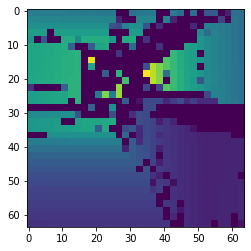

In [7]:
x1_ups = novel_view_synthesis(x1, x1, x1, x1)
print(x1_ups.shape)
plt.imshow(image_tensor_to_numpy(x1_ups))

torch.Size([1, 64, 64])


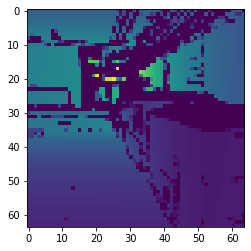

In [8]:
print(x2.shape)
plt.imshow(image_tensor_to_numpy(x2))

torch.Size([1, 128, 128])


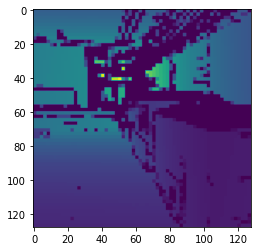

In [9]:
x2_ups = novel_view_synthesis(x2, x2, x2, x2)
print(x2_ups.shape)
plt.imshow(image_tensor_to_numpy(x2_ups))

torch.Size([1, 128, 128])


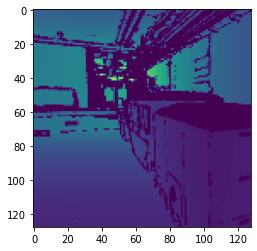

In [10]:
print(x4.shape)
plt.imshow(image_tensor_to_numpy(x4))

In [55]:
def novel_view_synthesis_batch(image_1_1_batch, image_1_2_batch, image_2_1_batch, image_2_2_batch):
    batch_size, channels, height, width = image_1_1_batch.shape
    canvas_batch = torch.zeros([batch_size, channels, height*2, width*2], dtype=torch.float64)
    for batch_idx in range(batch_size):
        image_1_1 = image_1_1_batch[batch_idx]
        image_1_2 = image_1_2_batch[batch_idx]
        image_2_1 = image_2_1_batch[batch_idx]
        image_2_2 = image_2_2_batch[batch_idx]
        
        even_images = [image_1_1, image_1_2]
        odd_images = [image_2_1, image_2_2]
        canvas = novel_view_synthesis(image_1_1, image_1_2, image_2_1, image_2_2)
        canvas_batch[batch_idx, :, :, :] = canvas
    return canvas_batch

In [85]:
def upscale(image_batch, scale_factor):
    batch_size, channels, height, width = image_batch.shape
    upscaled_batch = torch.zeros([batch_size, channels, height*scale_factor, width*scale_factor], dtype=torch.float64)
    for batch_idx in range(batch_size):
        image = tvf.resize(image_batch[batch_idx], (height*scale_factor, width*scale_factor))
        upscaled_batch[batch_idx, :, :, :] = image
    return upscaled_batch

In [86]:
train_dataloader = DataLoader(train_dataset, batch_size=4)

In [87]:
for x1_batch, x2_batch, x4_batch, x8_batch, x16_batch in train_dataloader:
    canvas_x1_to_x2 = novel_view_synthesis_batch(x1_batch, x1_batch, x1_batch, x1_batch)
    x1_batch_ups = upscale(x1_batch, 2)
    break

In [88]:
print(x1_batch_ups.shape)
print(canvas_x1_to_x2.shape)

torch.Size([4, 1, 64, 64])
torch.Size([4, 1, 64, 64])


In [89]:
x1_image = x1_batch_ups[3]
canvas_image = canvas_x1_to_x2[3]

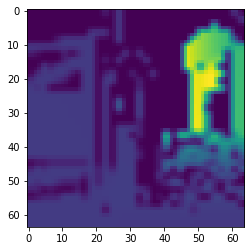

In [90]:
plt.imshow(image_tensor_to_numpy(x1_image))

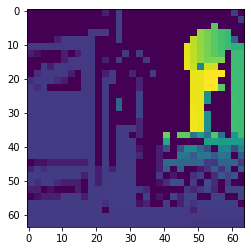

In [91]:
plt.imshow(image_tensor_to_numpy(canvas_image))

In [92]:
print(x1_image.max())
print(canvas_image.max())

tensor(246.9375, dtype=torch.float64)
tensor(247., dtype=torch.float64)
